# Trash

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import cv2
import glob
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
#from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA

path_to_dataset = "../dataset/slides/RECHERCHE-015.npy"
path_to_labels = "../dataset/annotations/RECHERCHE-015_label-015.npy"

In [ ]:
class ImageHelpers:
    def __init__(self):
        self.sift_object = cv2.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]

In [ ]:
class Descriptors:
    def __init__(self, dataset):
        self.dataset = dataset
        self.im_helper = ImageHelpers()
    
    def GetFeatures(self):
        descriptor_list = list()
        #for word, imlist in self.dataset:
        for image in self.dataset:
            _, des = self.im_helper.features(image)
            if des is None:
                continue
            descriptor_list.append(des)
        return descriptor_list

In [8]:
# Data reshape 
#dataset = np.load(path_to_dataset)[0:500]
datax = result.reshape(-1, 200*200*3)

In [ ]:
#dataset = np.load(path_to_dataset)[0:50]
#descriptor = Descriptors(dataset)
#descriptors_list_train = descriptor.GetFeatures()
#descriptors_train = np.concatenate(descriptors_list_train, axis=0)

In [ ]:
#len(descriptors_train[0])

128

In [9]:
#K-Means
n_clusters = 10
kmeans = KMeans(n_clusters = n_clusters, random_state = 0, n_init='auto')
kmeans_pred_train = kmeans.fit_predict(datax)

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
kmeans_pred_train

In [ ]:
# Plots
def plt_image(image, label):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(label)
    # Mostra i subplot affiancati
    plt.show()

In [ ]:
maschera = np.where(kmeans_pred_train == 1)
len(maschera[0])

6

In [ ]:
for i in range(0, len(maschera[0])):
  plt_image(dataset[maschera[0][i]], kmeans_pred_train[maschera[0][i]])

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


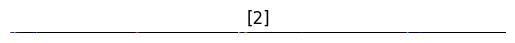

In [ ]:
for i in range(40,46):
  plt_image(dataset[i], kmeans_pred_train[i])

<Axes: >

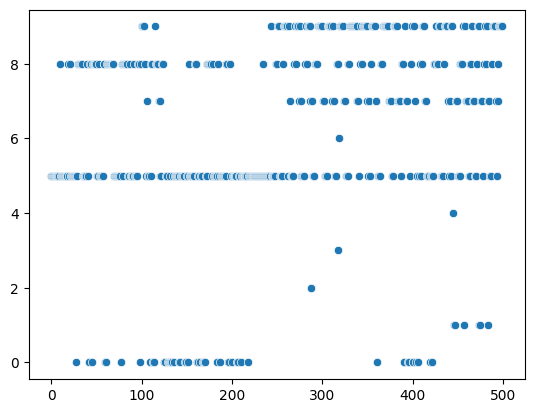

In [ ]:
import seaborn as sns

sns.scatterplot(data = kmeans_pred_train)

In [ ]:
x_data = [i for i in range(400*400*3)]
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'red',alpha=0.2)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'blue',alpha=0.2)
plt.scatter(x_data,kmeans.cluster_centers_[2] , color = 'green',alpha=0.2)

In [ ]:
kmeans.cluster_centers_[1]

array([240.91666667, 242.33333333, 240.66666667, ..., 229.91666667,
       225.70833333, 227.91666667])

# Extrapolate Glomeruli

In [2]:
path_to_dataset = "../dataset/slides/RECHERCHE-015.npy"
path_to_labels = "../dataset/annotations/RECHERCHE-015_label.npy"

In [3]:
dataset = np.load(path_to_dataset)
labels = np.load(path_to_labels)

In [4]:
# Identification of images and labels with glomerulus
glomeruli = np.array([dataset[i] for i in range(len(dataset)) if (1 in labels[i])])
glomeruli_labels = np.array([labels[i] for i in range(len(dataset)) if (1 in labels[i])])

# Identification of images and labels without glomerulus
notGlomeruli = np.array([dataset[i] for i in range(len(dataset)) if not(1 in labels[i])])
notGlomeruli_labels = np.array([labels[i] for i in range(len(dataset)) if not(1 in labels[i])])

In [5]:
# Function to save glomerolus areas into 200x200 images
def glomeruli_crop(glomeruli, glomeruli_labels):
    result = []
    for j in range(0, len(glomeruli)):
        num_labels, labels = cv2.connectedComponents(
            glomeruli_labels[j], connectivity=8)
        for i in range(1, num_labels):
            image = glomeruli[j]
            # Find row and column indices of pixels with value 1
            yrow, xcol = np.where(labels == i)

            # Calculate minimum and maximum row indices
            yrowmin = np.min(yrow)
            yrowmax = np.max(yrow)

            # Calculate minimum and maximum column indices
            xcolmin = np.min(xcol)
            xcolmax = np.max(xcol)

            # Calculate the size of the side of the square as the max between the height and the width
            side = max(yrowmax - yrowmin + 1, xcolmax - xcolmin + 1)
            if (side >= 20):
                # Adjust the bounding box to be square
                yrowmin = max(
                    0, yrowmin - (side - (yrowmax - yrowmin + 1)) // 2)
                yrowmax = yrowmin + side
                if yrowmax > image.shape[0]:
                    yrowmax = image.shape[0]
                    yrowmin = yrowmax - side
                xcolmin = max(
                    0, xcolmin - (side - (xcolmax - xcolmin + 1)) // 2)
                xcolmax = xcolmin + side
                if xcolmax > image.shape[1]:
                    xcolmax = image.shape[1]
                    xcolmin = xcolmax - side

                # Extract the square image from the original image
                cropped_image = image[yrowmin:yrowmax, xcolmin:xcolmax]
                # Resize image
                resized_image = cv2.resize(
                    cropped_image, (200, 200), interpolation=cv2.INTER_AREA)
                result.append(resized_image)
    return np.array(result)


In [6]:
dhresult = glomeruli_crop(glomeruli, glomeruli_labels)


In questo codice, dopo aver calcolato le dimensioni del lato del quadrato, regoliamo le coordinate minime e massime del bounding box per ottenere una forma quadrata, assicurandoci che il bounding box non esca dai bordi dell'immagine. Infine, estrapoliamo l'immagine quadrata dall'immagine originale.

In [7]:
result.shape

(172, 200, 200, 3)

In [94]:
# Save each image in a different file 
for i in range(0, len(result)):
    cv2.imwrite(f'image{i}.jpg', result[i])
